<a href="https://colab.research.google.com/github/mejihero/mmdetection_object_detection_demo/blob/master/Copy_of_mmdetection_train_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train an object detection model with mmdetection](https://www.dlology.com/blog/how-to-train-an-object-detection-model-with-mmdetection/) | DLology blog

In [0]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'faster_rcnn_r50_fpn_1x': {
        'config_file': 'configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py'
    },
    'cascade_rcnn_r50_fpn_1x': {
        'config_file': 'configs/cascade_rcnn_r50_fpn_1x.py',
    },
    'retinanet_r50_fpn_1x': {
        'config_file': 'configs/retinanet_r50_fpn_1x.py',
    }
}

## Your settings

In [0]:
# TODO: change URL to your fork of my repository if necessary.
#git_repo_url = 'https://github.com/Tony607/mmdetection_object_detection_demo'
git_repo_url = 'https://github.com/mejihero/mmdetection_object_detection_demo'

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_r50_fpn_1x'  # 'cascade_rcnn_r50_fpn_1x'

# Total training epochs.
total_epochs = 8

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

## Install Open MMLab Detection Toolbox
Restart the runtime if you have issue importing `mmdet` later on.


In [5]:
import os
from os.path import exists, join, basename, splitext

%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")
if not exists(project_name):
    # clone "depth 1" will only get the latest copy of the relevant files.
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    print("Update mmdetection repo")
    !cd {mmdetection_dir} && git checkout master && git pull
    # dependencies
    !pip install -q mmcv terminaltables
    # build
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}


import sys
sys.path.append(mmdetection_dir)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

/content


## Stash the repo if you want to re-modify `voc.py` and config file.

In [0]:
# !cd {mmdetection_dir} && git config --global user.email "zcw607@gmail.com" && git config --global user.name "Tony607" && git stash

## Modify `voc.py`
### parse data classes

In [7]:
%cd {project_name}

/content/mmdetection_object_detection_demo


In [0]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [0]:
anno_path = os.path.join(project_name, "data/VOC2007/Annotations")
voc_file = os.path.join(mmdetection_dir, "mmdet/datasets/voc.py")

In [10]:
classes_names = []
xml_list = []
for xml_file in glob.glob(anno_path + "/*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall("object"):
        classes_names.append(member[0].text)
classes_names = list(set(classes_names))
classes_names.sort()
classes_names

['date', 'fig', 'hazelnut']

In [11]:
import re

fname = voc_file
with open(fname) as f:
    s = f.read()
    s = re.sub('CLASSES = \(.*?\)',
               'CLASSES = ({})'.format(", ".join(["\'{}\'".format(name) for name in classes_names])), s, flags=re.S)
with open(fname, 'w') as f:
    f.write(s)
!cat {voc_file}

from .registry import DATASETS
from .xml_style import XMLDataset


@DATASETS.register_module
class VOCDataset(XMLDataset):

    CLASSES = ('date', 'fig', 'hazelnut')

    def __init__(self, **kwargs):
        super(VOCDataset, self).__init__(**kwargs)
        if 'VOC2007' in self.img_prefix:
            self.year = 2007
        elif 'VOC2012' in self.img_prefix:
            self.year = 2012
        else:
            raise ValueError('Cannot infer dataset year from img_prefix')


## Modify config file

In [12]:
import os
config_fname = os.path.join(project_name, 'mmdetection', config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'/content/mmdetection_object_detection_demo/mmdetection/configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py'

In [13]:
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = re.findall(r"work_dir = \'(.*?)\'", s)[0]
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('ann_file=.*?\],',
               "ann_file=data_root + 'VOC2007/ImageSets/Main/trainval.txt',", s, flags=re.S)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} #'.format(total_epochs), s)
    if "CocoDataset" in s:
        s = re.sub("dataset_type = 'CocoDataset'",
                   "dataset_type = 'VOCDataset'", s)
        s = re.sub("data_root = 'data/coco/'",
                   "data_root = 'data/VOCdevkit/'", s)
        s = re.sub("annotations/instances_train2017.json",
                   "VOC2007/ImageSets/Main/trainval.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("train2017", "VOC2007", s)
        s = re.sub("val2017", "VOC2007", s)
    else:
        s = re.sub('img_prefix=.*?\],',
                   "img_prefix=data_root + 'VOC2007/',".format(total_epochs), s)
with open(fname, 'w') as f:
    f.write(s)
!cat {config_fname}

# model settings
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    bbox_roi_extractor=dict(
        type='SingleRoIExtractor',
        roi_layer=dict(type='RoIAlign', out_size=7, sample_num=2),
        out_channels=

In [14]:
%cd {mmdetection_dir}
!python setup.py install

/content/mmdetection_object_detection_demo/mmdetection
/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:474: UserWarning: Normalizing '1.0.rc0+ff28413' to '1.0rc0+ff28413'
  normalized_version,
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mmdet/version.py -> build/lib.linux-x86_64-3.6/mmdet
copying mmdet/datasets/voc.py -> build/lib.linux-x86_64-3.6/mmdet/datasets
running build_ext
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mmdet
creating build/bdist.linux-x86_64/egg/mmdet/ops
copying build/lib.linux-x86_64-3.6/mmdet/ops/context_block.py -> build/bdist.linux-x86_64/egg/mmdet/ops
creating b

In [16]:
os.makedirs("data/VOCdevkit", exist_ok=True)
voc2007_dir = os.path.join(project_name, "data/VOC2007")
os.system("ln -s {} data/VOCdevkit".format(voc2007_dir))

256

In [17]:
!python tools/train.py {config_fname}

2019-10-12 10:36:50,325 - INFO - Distributed training: False
2019-10-12 10:36:50,842 - INFO - load model from: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:02<00:00, 49.3MB/s]
2019-10-12 10:36:53,337 - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2019-10-12 10:36:59,282 - INFO - Start running, host: root@ef4735ab6edc, work_dir: /content/mmdetection_object_detection_demo/mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_voc0712
2019-10-12 10:36:59,282 - INFO - workflow: [('train', 1)], max: 8 epochs


In [18]:
checkpoint_file = os.path.join(mmdetection_dir, work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file

'/content/mmdetection_object_detection_demo/mmdetection/./work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth'

## Test predict

Turn down the `score_thr` if you think the model is missing any bbox.
Turn up the `score_thr` if you see too much overlapping bboxes with low scores.

In [0]:
#!pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}

In [0]:
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab


def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result, init_detector

/content/mmdetection_object_detection_demo/mmdetection


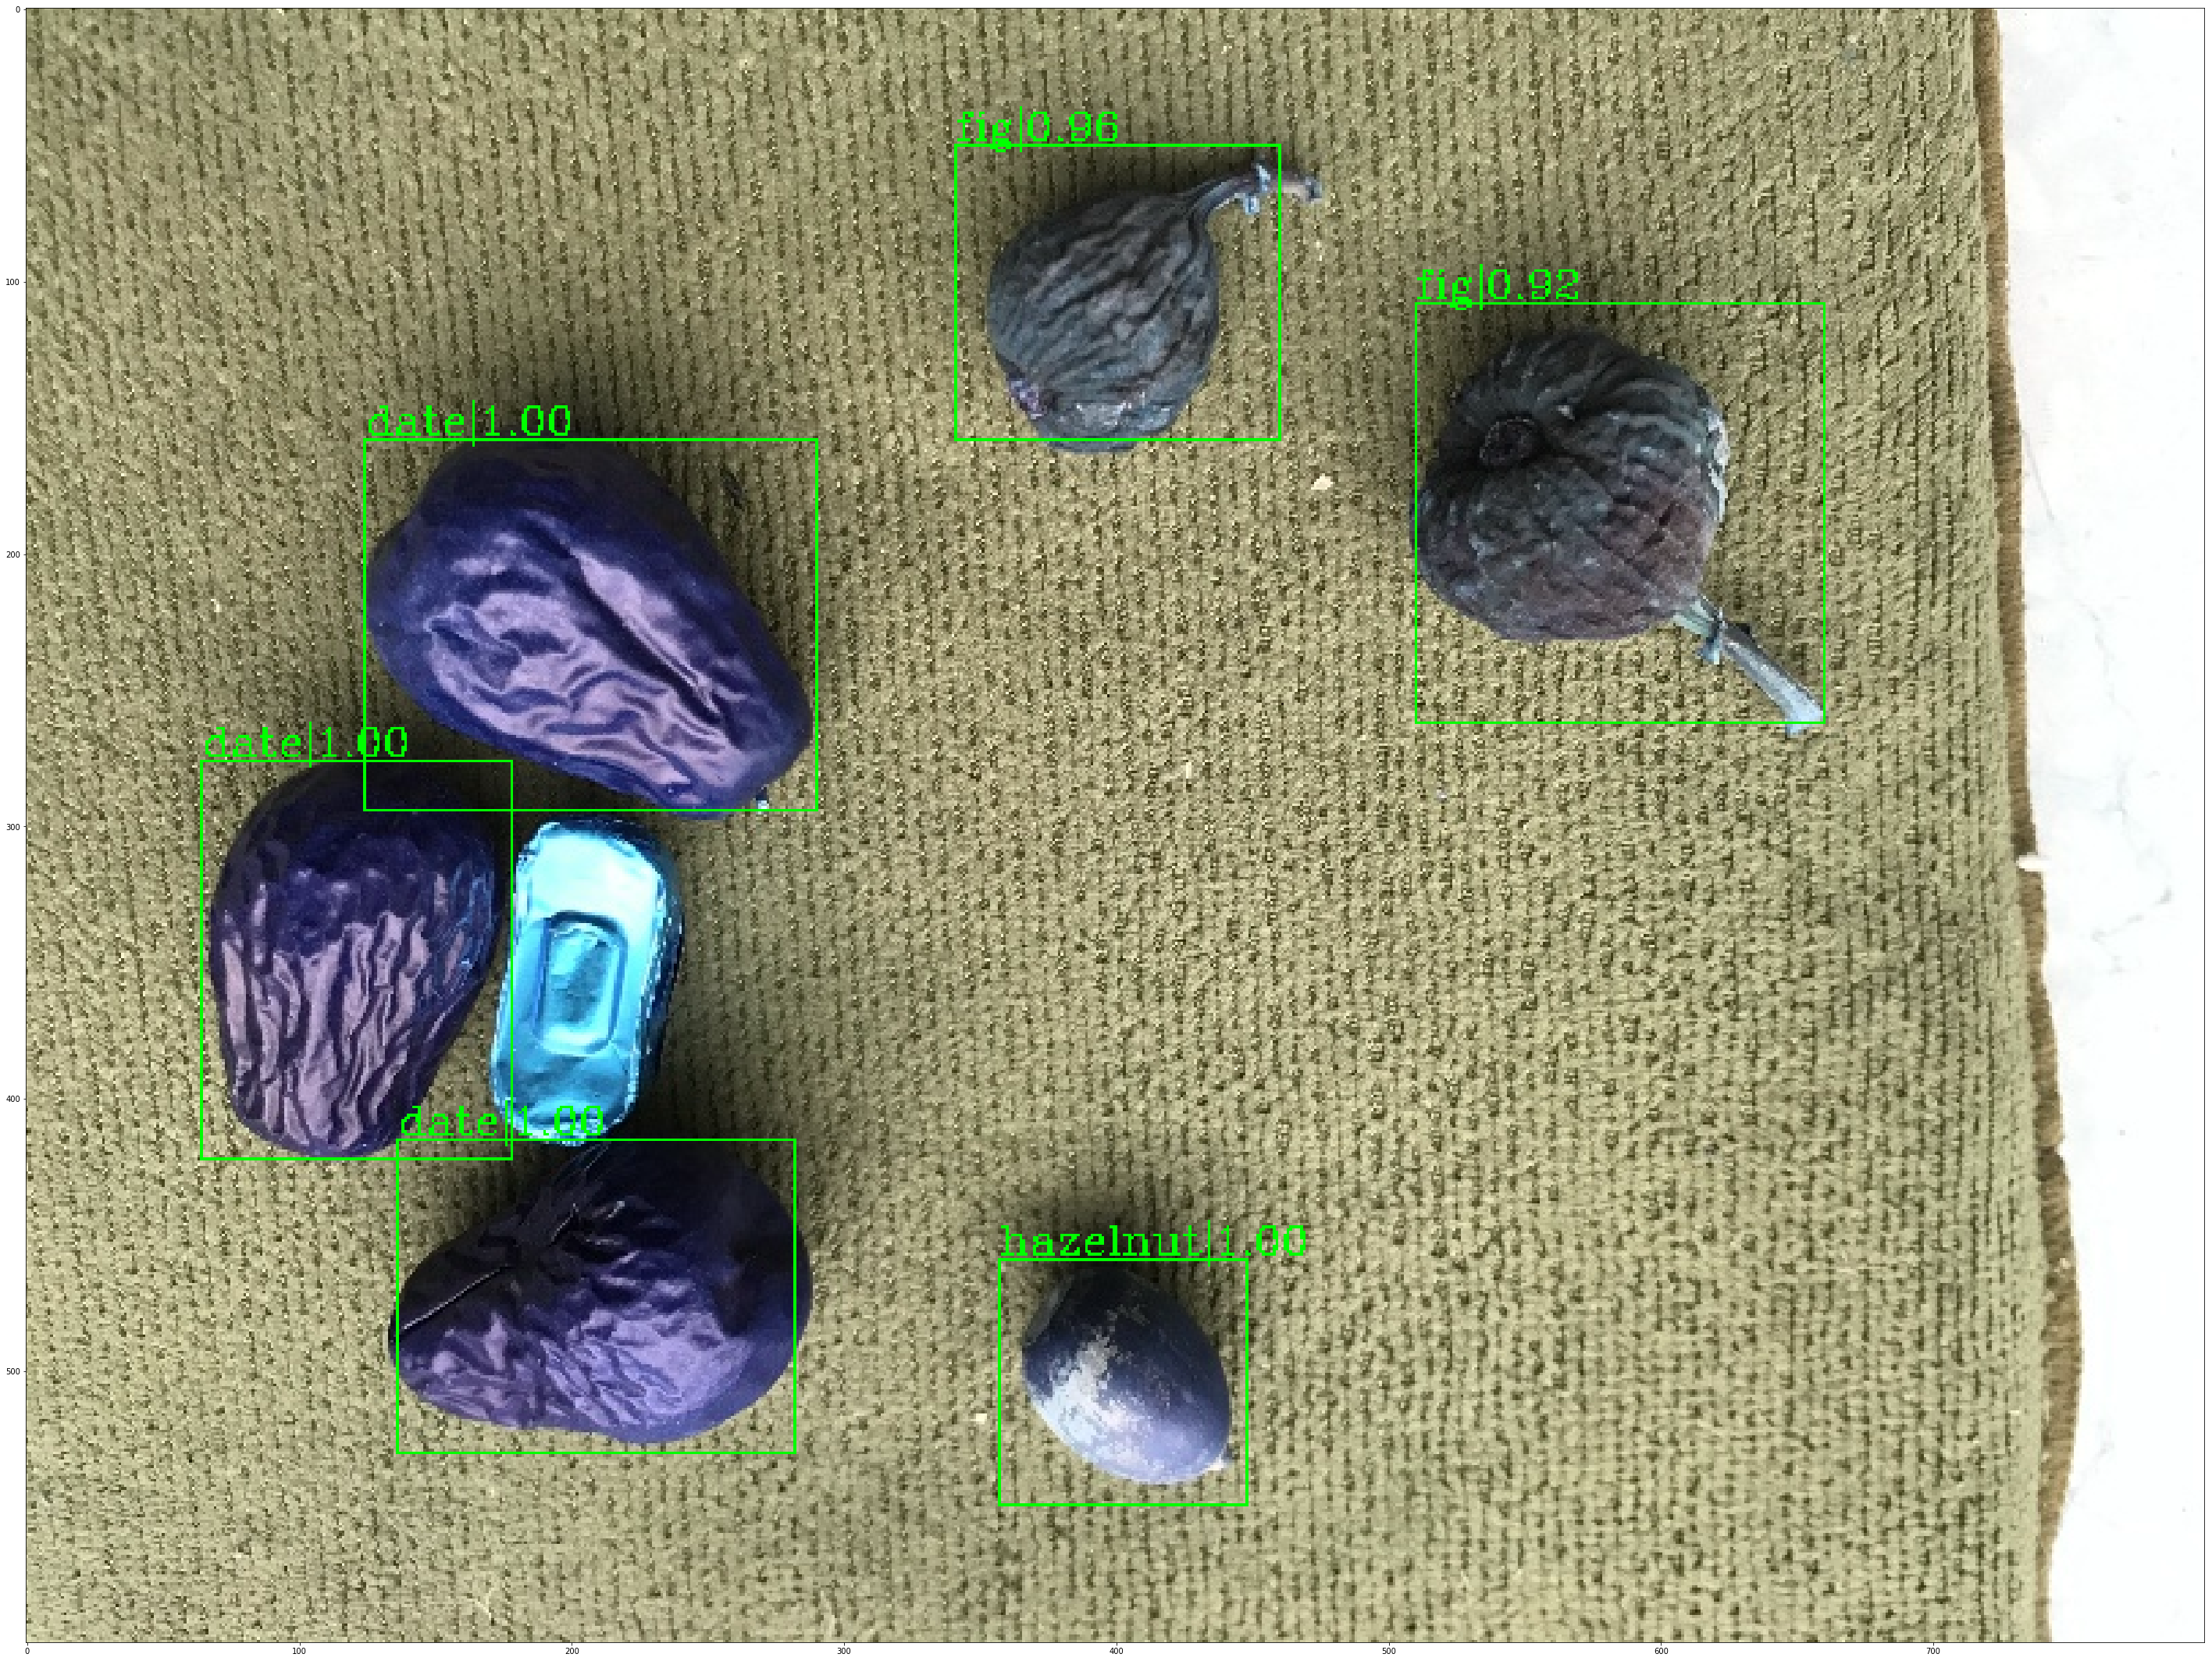

In [19]:
%cd {mmdetection_dir}

score_thr = 0.8

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = 'data/VOCdevkit/VOC2007/JPEGImages/15.jpg'
result = inference_detector(model, img)
show_result(img, result, model.CLASSES,
            score_thr=score_thr, out_file="result.jpg")

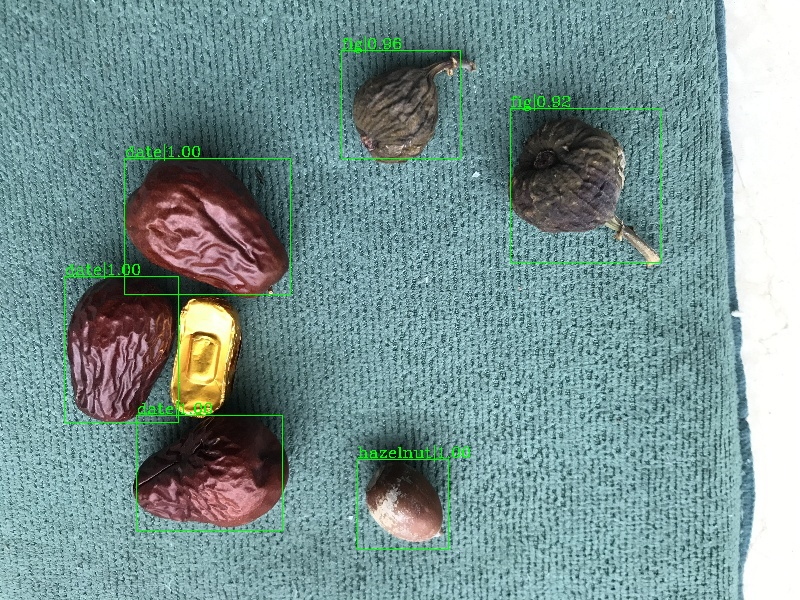

In [20]:
from IPython.display import Image
Image(filename='result.jpg')

## Download the config file

In [0]:
from google.colab import files

files.download(config_fname)

## Download checkpoint file.

### Option1 : upload the checkpoint file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(checkpoint_file)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(checkpoint_file)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the checkpoint file directly to your local file system
This method may not be stable when downloading large files like the model checkpoint file. Try **option 1** instead if not working.

In [0]:
files.download(checkpoint_file)